In [1]:
#Final code of the project to detect damaged tissues on the lungs

## Preprocessing

In [2]:
#importing libraries as needed
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import warnings
warnings.filterwarnings('ignore')
from PIL import Image 
from PIL.ImageDraw import Draw

from keras.models import load_model
import keras
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

In [3]:
#read in csv files
csv_path = 'csv_files/'
df_image_id = pd.read_csv(csv_path + 'nih-cxr-lt_image_ids.csv')
df_label_train = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_train.csv')
df_label_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_test.csv')
df_balanced_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-test.csv')
df_balanced_val = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-val.csv')
#there are 5 files:
#all image ids
#balanced testing dataset
#balanced validation dataset
#normal testing dataset
#normal training dataset

#fixing naming convention of a columns
df_label_train.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_train.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_train.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_train.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_label_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_val.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_val.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)

#create new dataframes that contain solely heart issues
#include columns only with heart related labels
#remove rows where all values are zero (no finding == 0 -> condition)
#cant do one liner for dropping so have to use conditional drop
df_label_train_heart = df_label_train[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_train_heart = df_label_train_heart.drop(df_label_train_heart[(df_label_train_heart.Cardiomegaly == 0) & (df_label_train_heart.Infiltration == 0) & (df_label_train_heart.Mass == 0) & (df_label_train_heart.Nodule == 0) & (df_label_train_heart.Tortuous_Aorta == 0) & (df_label_train_heart.Calcification_of_the_Aorta == 0) & (df_label_train_heart.No_Finding == 0) ].index)
df_label_test_heart = df_label_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_test_heart = df_label_test_heart.drop(df_label_test_heart[(df_label_test_heart.Cardiomegaly == 0) & (df_label_test_heart.Infiltration == 0) & (df_label_test_heart.Mass == 0) & (df_label_test_heart.Nodule == 0) & (df_label_test_heart.Tortuous_Aorta == 0) & (df_label_test_heart.Calcification_of_the_Aorta == 0) & (df_label_test_heart.No_Finding == 0) ].index)
df_balanced_test_heart = df_balanced_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_test_heart = df_balanced_test_heart.drop(df_balanced_test_heart[(df_balanced_test_heart.Cardiomegaly == 0) & (df_balanced_test_heart.Infiltration == 0) & (df_balanced_test_heart.Mass == 0) & (df_balanced_test_heart.Nodule == 0) & (df_balanced_test_heart.Tortuous_Aorta == 0) & (df_balanced_test_heart.Calcification_of_the_Aorta == 0) & (df_balanced_test_heart.No_Finding == 0) ].index)
df_balanced_val_heart = df_balanced_val[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_val_heart = df_balanced_val_heart.drop(df_balanced_val_heart[(df_balanced_val_heart.Cardiomegaly == 0) & (df_balanced_val_heart.Infiltration == 0) & (df_balanced_val_heart.Mass == 0) & (df_balanced_val_heart.Nodule == 0) & (df_balanced_val_heart.Tortuous_Aorta == 0) & (df_balanced_val_heart.Calcification_of_the_Aorta == 0) & (df_balanced_val_heart.No_Finding == 0) ].index)
display(df_label_train_heart)

# #create new dataframes that contain solely lung issues (what we are currently concerned with)
# #include columns only with lung related labels
# #remove rows where all values are zero
df_label_train_lung = df_label_train[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[(df_label_train_lung.Atelectasis == 0) & (df_label_train_lung.Consolidation == 0) & (df_label_train_lung.Edema == 0) & (df_label_train_lung.Effusion == 0) & (df_label_train_lung.Emphysema == 0) & (df_label_train_lung.Fibrosis == 0) & (df_label_train_lung.Hernia == 0) & (df_label_train_lung.Infiltration == 0) & (df_label_train_lung.Mass == 0) & (df_label_train_lung.Nodule == 0) & (df_label_train_lung.Pleural_Thickening == 0) & (df_label_train_lung.Pneumonia == 0) & (df_label_train_lung.Pneumothorax == 0)& (df_label_train_lung.Pneumomediastinum == 0) & (df_label_train_lung.No_Finding == 0)].index)
df_label_test_lung = df_label_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[(df_label_test_lung.Atelectasis == 0) & (df_label_test_lung.Consolidation == 0) & (df_label_test_lung.Edema == 0) & (df_label_test_lung.Effusion == 0) & (df_label_test_lung.Emphysema == 0) & (df_label_test_lung.Fibrosis == 0) & (df_label_test_lung.Hernia == 0) & (df_label_test_lung.Infiltration == 0) & (df_label_test_lung.Mass == 0) & (df_label_test_lung.Nodule == 0) & (df_label_test_lung.Pleural_Thickening == 0) & (df_label_test_lung.Pneumonia == 0) & (df_label_test_lung.Pneumothorax == 0)& (df_label_test_lung.Pneumomediastinum == 0) & (df_label_test_lung.No_Finding == 0)].index)
df_balanced_test_lung = df_balanced_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[(df_balanced_test_lung.Atelectasis == 0) & (df_balanced_test_lung.Consolidation == 0) & (df_balanced_test_lung.Edema == 0) & (df_balanced_test_lung.Effusion == 0) & (df_balanced_test_lung.Emphysema == 0) & (df_balanced_test_lung.Fibrosis == 0) & (df_balanced_test_lung.Hernia == 0) & (df_balanced_test_lung.Infiltration == 0) & (df_balanced_test_lung.Mass == 0) & (df_balanced_test_lung.Nodule == 0) & (df_balanced_test_lung.Pleural_Thickening == 0) & (df_balanced_test_lung.Pneumonia == 0) & (df_balanced_test_lung.Pneumothorax == 0) & (df_balanced_test_lung.Pneumomediastinum == 0) & (df_balanced_test_lung.No_Finding == 0)].index)
df_balanced_val_lung = df_balanced_val[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[(df_balanced_val_lung.Atelectasis == 0) & (df_balanced_val_lung.Consolidation == 0) & (df_balanced_val_lung.Edema == 0) & (df_balanced_val_lung.Effusion == 0) & (df_balanced_val_lung.Emphysema == 0) & (df_balanced_val_lung.Fibrosis == 0) & (df_balanced_val_lung.Hernia == 0) & (df_balanced_val_lung.Infiltration == 0) & (df_balanced_val_lung.Mass == 0) & (df_balanced_val_lung.Nodule == 0) & (df_balanced_val_lung.Pleural_Thickening == 0) & (df_balanced_val_lung.Pneumonia == 0) & (df_balanced_val_lung.Pneumothorax == 0) & (df_balanced_val_lung.Pneumomediastinum == 0) & (df_balanced_val_lung.No_Finding == 0)].index)
display(df_label_train_lung)

#saving new dataframes
df_label_train_heart.to_csv(csv_path + 'label_train_heart.csv', index=False)
df_label_test_heart.to_csv(csv_path + 'label_test_heart.csv', index=False)
df_balanced_test_heart.to_csv(csv_path + 'balanced_test_heart.csv', index=False)
df_balanced_val_heart.to_csv(csv_path + 'balanced_val_heart.csv', index=False)
df_label_train_lung.to_csv(csv_path + 'label_train_lung.csv', index=False)
df_label_test_lung.to_csv(csv_path + 'label_test_lung.csv', index=False)
df_balanced_test_lung.to_csv(csv_path + 'balanced_test_lung.csv', index=False)
df_balanced_val_lung.to_csv(csv_path + 'balanced_val_lung.csv', index=False)

,id,Cardiomegaly,Infiltration,Mass,Nodule,Tortuous_Aorta,Calcification_of_the_Aorta,No_Finding,subject_id
0,00000001_000.png,1,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,1,30804


,id,Atelectasis,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumomediastinum,No_Finding,subject_id
1,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
5,00000005_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30804


In [4]:
#selecting wanted data values for predicting lung cancer (id, Mass, Nodule, No_Finding)
cancer_train = df_label_train_lung[(df_label_train_lung.Nodule == 1) | (df_label_train_lung.Mass == 1) | (df_label_train_lung.No_Finding == 1)]
cancer_val = df_balanced_val_lung[(df_balanced_val_lung.Nodule == 1) | (df_balanced_val_lung.Mass == 1) | (df_balanced_val_lung.No_Finding == 1)]
cancer_test = df_label_test_lung[(df_label_test_lung.Nodule == 1) | (df_label_test_lung.Mass == 1) | (df_label_test_lung.No_Finding == 1)]
#selecting only relevant columns 
cancer_train = cancer_train[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_val = cancer_val[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_test = cancer_test[['id', 'Mass', 'Nodule', 'No_Finding']]

In [5]:
#consolidating the data and one hot encoding
conditions = [(cancer_train['No_Finding']==1),
              (cancer_train['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_train['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_train['target'])
cancer_train = cancer_train.join(encoded)
cancer_train = cancer_train.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_train.rename(columns = {cancer_train.columns[1]:'cancer_negative', cancer_train.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_train)

,id,cancer_negative,cancer_positive
1,00000002_000.png,1,0
2,00000005_000.png,1,0
3,00000005_001.png,1,0
4,00000005_002.png,1,0
5,00000005_003.png,1,0
...,...,...,...
68053,00030801_000.png,1,0
68054,00030802_000.png,1,0
68055,00030803_000.png,1,0
68056,00030804_000.png,1,0


In [6]:
conditions = [(cancer_val['No_Finding']==1),
              (cancer_val['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_val['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_val['target'])
cancer_val = cancer_val.join(encoded)
cancer_val = cancer_val.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_val.rename(columns = {cancer_val.columns[1]:'cancer_negative', cancer_val.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_val)

,id,cancer_negative,cancer_positive
135,00004532_000.png,0,1
136,00004532_002.png,0,1
137,00004532_003.png,0,1
138,00015196_000.png,0,1
139,00015196_001.png,0,1
140,00015196_003.png,0,1
141,00015196_006.png,0,1
142,00015196_008.png,0,1
143,00015196_010.png,0,1
144,00018101_000.png,0,1


In [7]:
conditions = [(cancer_test['No_Finding']==1),
              (cancer_test['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_test['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_test['target'])
cancer_test = cancer_test.join(encoded)
cancer_test = cancer_test.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_test.rename(columns = {cancer_test.columns[1]:'cancer_negative', cancer_test.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_test)

,id,cancer_negative,cancer_positive
7,00000015_000.png,1,0
8,00000018_000.png,1,0
12,00000038_002.png,1,0
14,00000038_004.png,1,0
15,00000038_005.png,1,0
...,...,...,...
20273,00030766_000.png,1,0
20274,00030777_000.png,1,0
20275,00030782_000.png,1,0
20277,00030797_000.png,1,0


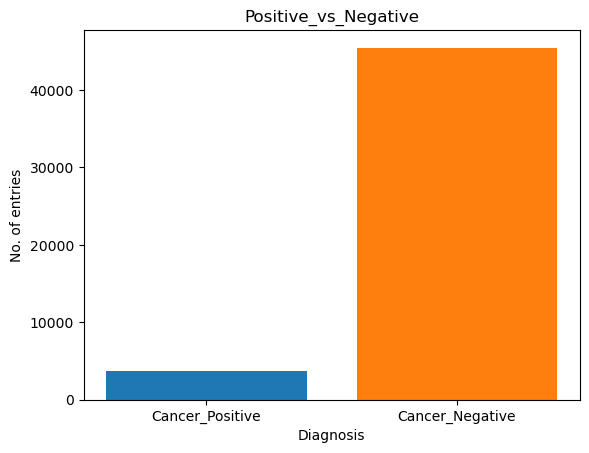

In [8]:
#plot of data
cancer_positive = len(cancer_train[cancer_train['cancer_negative'] == 0].index)
cancer_negative = len(cancer_train[cancer_train['cancer_negative'] == 1].index)
  
plt.bar('Cancer_Positive' ,cancer_positive, label= 'Positive')
plt.bar('Cancer_Negative' ,cancer_negative, label = 'Negative')
plt.xlabel("Diagnosis")
plt.ylabel("No. of entries")
plt.title("Positive_vs_Negative")
plt.show()

In [9]:
#add pathing to front of images in csv (chest_xrays/)
cancer_train['id'] = 'chest_xrays/' + cancer_train['id'].astype(str)
cancer_val['id'] = 'chest_xrays/' + cancer_val['id'].astype(str)
cancer_test['id'] = 'chest_xrays/' + cancer_test['id'].astype(str)

In [10]:
#adding entries from train to validation due to lack of entries
val_add = cancer_train[40000:49141]
cancer_train = cancer_train[0:40000]
cancer_val = cancer_val.append(val_add)

In [11]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [12]:
#preprocessing of training images
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=cancer_train,
                                                   x_col="id",
                                                   y_col="cancer_positive", #can add more categories here
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=50,
                                                   subset="training")

Found 36000 validated image filenames.


In [13]:
Validation_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [14]:
#preprocessing of validation images
Validation_IMG_Set = Validation_Generator.flow_from_dataframe(dataframe=cancer_val,
                                                   x_col="id",
                                                   y_col="cancer_positive",
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=100,
                                                   subset="validation")

Found 918 validated image filenames.


In [15]:
Test_Generator = ImageDataGenerator(rescale=1./255)

In [16]:
#preprocessing of testing images
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=cancer_test,
                                                 x_col="id",
                                                 y_col="cancer_positive",
                                                 color_mode="rgb",
                                                 class_mode="raw",
                                                 batch_size=100)

Found 14024 validated image filenames.


## Model Making, Training, Saving, and Evaluation

In [17]:
input_shape = (256,256,3)

alex_net = keras.models.Sequential()
# 1st convolution layer
alex_net.add(Conv2D(filters=96,input_shape=input_shape, activation="relu", padding="same", kernel_size=(11,11), strides=(4,4)))
# Max Pooling
alex_net.add(MaxPooling2D(pool_size=(3,3), padding="same", strides=(2,2))) 

# 2nd convolution layer
alex_net.add(Conv2D(filters=256, activation="relu", padding="same", kernel_size=(5,5), strides=(1,1))) 
# Max Pooling
alex_net.add(MaxPooling2D(pool_size=(3,3), padding="same", strides=(2,2)))

# 3rd convolution layer
alex_net.add(Conv2D(filters=384, activation="relu", padding="same", kernel_size=(3,3), strides=(1,1))) 

# 4th convolution layer
alex_net.add(Conv2D(filters=384, activation="relu", padding="same", kernel_size=(3,3), strides=(1,1))) 

# 5th convolution layer
alex_net.add(Conv2D(filters=256, activation="relu", padding="same", kernel_size=(3,3), strides=(1,1))) 
# Max Pooling
alex_net.add(MaxPooling2D(pool_size=(3,3), padding="same", strides=(2,2))) 

# flatten model
alex_net.add(Flatten())

# 1st fully connected layer 
alex_net.add(Dense(4096, activation="relu"))
# Add dropout layer
alex_net.add(Dropout(0.5))

# 2nd fully connected layer 
alex_net.add(Dense(4096, activation="relu"))
# Add dropout layer
alex_net.add(Dropout(0.5))

# Add output layer
alex_net.add(Dense(1, activation="softmax")) 
alex_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 384)       1

In [18]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
alex_net.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("alex_net_clean_standardized.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = alex_net.fit_generator(steps_per_epoch=100,generator=Train_IMG_Set, validation_data= Validation_IMG_Set, validation_steps=10,epochs=20,callbacks=[checkpoint,early])

Epoch 1/20
100/100 [==============================] - 629s 6s/step - loss: 0.0000e+00 - accuracy: 0.0812 - val_loss: 0.0000e+00 - val_accuracy: 0.1057
Epoch 2/20
100/100 [==============================] - 615s 6s/step - loss: nan - accuracy: 0.4602 - val_loss: nan - val_accuracy: 0.8943
Epoch 3/20
100/100 [==============================] - 614s 6s/step - loss: nan - accuracy: 0.9240 - val_loss: nan - val_accuracy: 0.8943
Epoch 4/20
100/100 [==============================] - 612s 6s/step - loss: nan - accuracy: 0.9248 - val_loss: nan - val_accuracy: 0.8943
Epoch 5/20
100/100 [==============================] - 611s 6s/step - loss: nan - accuracy: 0.9226 - val_loss: nan - val_accuracy: 0.8943
Epoch 6/20
100/100 [==============================] - 624s 6s/step - loss: nan - accuracy: 0.9262 - val_loss: nan - val_accuracy: 0.8943
Epoch 7/20
100/100 [==============================] - 634s 6s/step - loss: nan - accuracy: 0.9254 - val_loss: nan - val_accuracy: 0.8943
Epoch 8/20
100/100 [=======

In [28]:
if os.path.isfile("alex_net_clean_standardized.h5") is False:
    alex_net.save('alex_net_clean_standardized.h5')
    print("model saved")

model saved


In [40]:
model = load_model("alex_net_clean_standardized.h5")
model.evaluate(Test_IMG_Set)

141/141 [==============================] - 625s 4s/step - loss: nan - accuracy: 0.9309


[nan, 0.9309041500091553]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


INFO:tensorflow:Assets written to: ram://5747f910-8920-4d21-af31-eaf7582411d1/assets


INFO:tensorflow:Assets written to: ram://5747f910-8920-4d21-af31-eaf7582411d1/assets


Stored 'hist' (History)


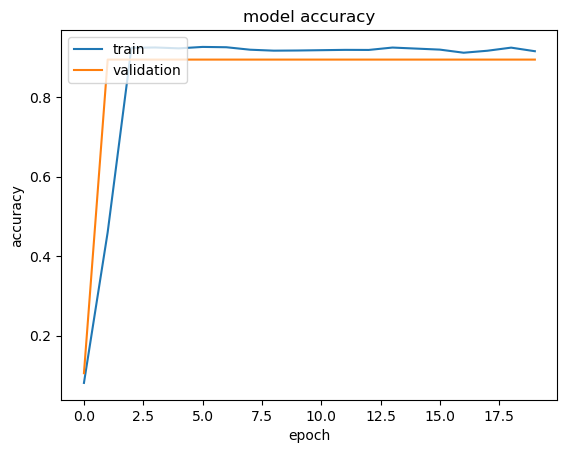

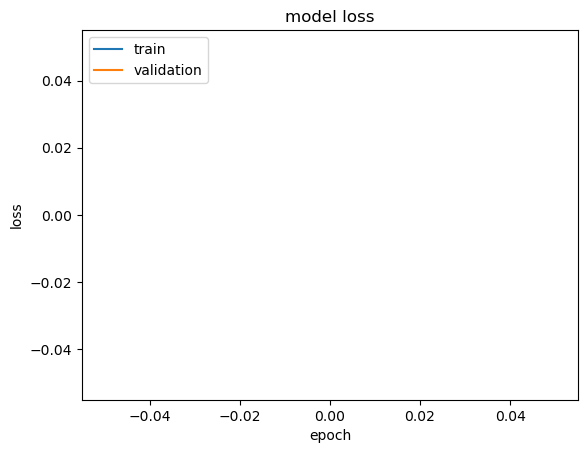

In [41]:
# list all data in history
print(hist.history.keys())
%store hist
#summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()